In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 20})
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
Nor_path = "./Dataset/Normal_mixed.csv"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
Nor_df = pd.read_csv(Nor_path, header=None,names= col_names, nrows= 10000)

In [3]:
Abnor_path = "./Dataset/Abnormal.csv"
Abnor_df = pd.read_csv(Abnor_path, header=None,names= col_names, nrows= 10000)

In [4]:
Train = pd.concat([Nor_df.iloc[:8000], Abnor_df.iloc[:8000]], ignore_index=True)
Train_nor = Nor_df.iloc[:8000]
Train_abnor = Abnor_df.iloc[:8000]

Test = pd.concat([Nor_df.iloc[-2000:], Abnor_df.iloc[-2000:]], ignore_index=True)
Test_nor = Nor_df.iloc[-2000:]
Test_abnor = Abnor_df.iloc[-2000:]

In [5]:
def nomial(dataset):
    protocol1 = dataset['protocol_type'].copy()
    protocol_type = ["tcp", "udp", "icmp"]
    for i in range(len(protocol_type)):
        protocol1[protocol1 == protocol_type[i]] = i / len(protocol_type)
    dataset['protocol_type'] = protocol1

    service1 = dataset['service'].copy()
    service_type = ["other", "private", "ecr_i", "urp_i", "urh_i", "red_i", "eco_i", "tim_i", "oth_i", "domain_u", "tftp_u", "ntp_u", "IRC",
                "X11", "Z39_50", "aol", "auth", "bgp", "courier", "csnet_ns", "ctf", "daytime", "discard", "domain", "echo", "efs", "exec",
                "finger", "ftp", "ftp_data", "gopher", "harvest", "hostnames", "http", "http_2784", "http_443", "http_8001", "icmp", "imap4",
                "iso_tsap", "klogin", "kshell", "ldap", "link", "login", "mtp", "name", "netbios_dgm", "netbios_ns", "netbios_ssn", "netstat",
                "nnsp", "nntp", "pm_dump", "pop_2", "pop_3", "printer", "remote_job", "rje", "shell", "smtp", "sql_net", "ssh", "sunrpc",
                "supdup", "systat", "telnet", "time", "uucp", "uucp_path", "vmnet", "whois"]
    for i in range(len(service_type)):
        service1[service1 == service_type[i]] = i / len(service_type)
    dataset['service'] = service1

    flag1 = dataset['flag'].copy()
    flag_type = ["SF", "S0", "S1", "S2", "S3", "REJ", "RSTOS0", "RSTO", "RSTR", "SH", "RSTRH", "SHR", "OTH"]
    for i in range(len(flag_type)):
        flag1[flag1 == flag_type[i]] = i / len(flag_type)
    dataset['flag'] = flag1

def scaler(dataset):
    # Duration:
    duration = dataset["duration"].copy()
    dataset["duration"] = duration / 2                              # Max duration in a window frame capture

    # Src bytes
    src_bytes = dataset["src_bytes"].copy()
    dataset["src_bytes"] = src_bytes / 65535                        # 2^16 bytes - Max size per TCP packet

    # Dst bytes
    dst_bytes = dataset["dst_bytes"].copy()
    dataset["dst_bytes"] = dst_bytes / 65535                        # 2^16 bytes - Max size per TCP packet

    # Count
    count = dataset["count"].copy()
    dataset["count"] = count / 5000                                 # 2s / minimum time-slot of ACK packets

    # Srv_count
    srv_count = dataset["srv_count"].copy()
    dataset["srv_count"] = srv_count / 5000                         # 2s / minimum time-slot of ACK packets

    # Dst_host_count
    dst_host_count = dataset["dst_host_count"].copy()
    dataset["dst_host_count"] = dst_host_count / 5000               # 2s / minimum time-slot of ACK packets

    # Dst_host_srv_count
    dst_host_srv_count = dataset["dst_host_srv_count"].copy()
    dataset["dst_host_srv_count"] = dst_host_srv_count / 5000       # 2s / minimum time-slot of ACK packets

In [6]:
nomial(Train_nor)
nomial(Test_nor)
nomial(Train_abnor)
nomial(Test_abnor)

scaler(Train_nor)
scaler(Train_abnor)
scaler(Test_nor)
scaler(Test_abnor)

nomial(Train)
scaler(Test)

nomial(Test)
scaler(Test)

In [7]:
num_features = ["duration", "protocol_type","service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]
Train_nor[num_features] = Train_nor[num_features].astype(float)
Test_nor[num_features] = Test_nor[num_features].astype(float)
Test_abnor[num_features] = Test_abnor[num_features].astype(float)
Train_abnor[num_features] = Train_abnor[num_features].astype(float)

Train[num_features] = Train[num_features].astype(float)
Test[num_features] = Test[num_features].astype(float)

In [8]:
Label_nor_train = Train_nor['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)
Label_abnor_train = Train_abnor['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)
Label_nor_test = Test_nor['label']
Label_abnor_test = Test_abnor['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

Label_Train = Train['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)
Label_Test = Test['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

In [9]:
Train_nor = Train_nor.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"])
Test_nor = Test_nor.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"])
Test_abnor = Test_abnor.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"])
Train_abnor = Train_abnor.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"])

Train = Train.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"])
Test = Test.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"])

In [10]:
print(Train_nor.shape)
print(Test_nor.shape)

(8000, 21)
(2000, 21)


In [11]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      # keras.layers.Dense(128, activation='tanh'),
      # keras.layers.Dense(64, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(8, activation='tanh')
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      # keras.layers.Dense(64, activation='tanh'),
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

  def get_reconstruction_error(self, x):
    r = self.predict(x)
    return keras.metrics.mean_squared_error(x, r)

  def predict_class(self, x, threshold):
    reconstruction_error = self.get_reconstruction_error(x)
    return np.where(reconstruction_error <= threshold, 'Normal', 'Abnormal')

In [12]:
model = Autoencoder(Train_nor.shape[1])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn, metrics = ['accuracy'])

In [13]:
model.fit(Train_nor, Train_nor, batch_size=500, epochs=300, shuffle=True)

Epoch 1/300


16/16 [==============================] - 0s 2ms/step - loss: 1.0902 - accuracy: 0.1262
Epoch 2/300
16/16 [==============================] - 0s 2ms/step - loss: 1.0826 - accuracy: 0.2686
Epoch 3/300
16/16 [==============================] - 0s 2ms/step - loss: 1.0750 - accuracy: 0.3285
Epoch 4/300
16/16 [==============================] - 0s 2ms/step - loss: 1.0674 - accuracy: 0.3386
Epoch 5/300
16/16 [==============================] - 0s 2ms/step - loss: 1.0597 - accuracy: 0.3643
Epoch 6/300
16/16 [==============================] - 0s 2ms/step - loss: 1.0519 - accuracy: 0.3669
Epoch 7/300
16/16 [==============================] - 0s 2ms/step - loss: 1.0439 - accuracy: 0.3704
Epoch 8/300
16/16 [==============================] - 0s 2ms/step - loss: 1.0358 - accuracy: 0.3663
Epoch 9/300
16/16 [==============================] - 0s 2ms/step - loss: 1.0277 - accuracy: 0.3570
Epoch 10/300
16/16 [==============================] - 0s 2ms/step - loss: 1.0196 - accuracy: 0.3410
Epoch 11/300
16/16 [=

In [14]:
train_normal_re = model.get_reconstruction_error(Train_nor)
train_abnormal_re = model.get_reconstruction_error(Train_abnor)

test_normal_re = model.get_reconstruction_error(Test_nor)
test_abnormal_re = model.get_reconstruction_error(Test_abnor)

63/63 [==============================] - 0s 1ms/step


In [15]:
alpha = 0.5
threshold = np.concatenate([train_normal_re, train_abnormal_re]).mean() * alpha
print('Ngưỡng vừa tìm được từ tập train:', threshold)

Ngưỡng vừa tìm được từ tập train: 0.5484809279441833


In [16]:
label_predict = model.predict_class(Test_abnor, threshold)
print('Độ chính xác tập khi tái tạo normal tập huấn luyện', end=': ')
print(accuracy_score(Label_abnor_test, label_predict))

label_predict = model.predict_class(Train, threshold)
print('Độ chính xác tập huấn luyện', end=': ')
print(accuracy_score(Label_Train, label_predict))

label_predict = model.predict_class(Test, threshold)
print('Độ chính xác tập test', end=': ')
print(accuracy_score(Label_Test, label_predict))

63/63 [==============================] - 0s 945us/step
Độ chính xác tập khi tái tạo normal tập huấn luyện: 0.186
500/500 [==============================] - 1s 1ms/step
Độ chính xác tập huấn luyện: 0.5
125/125 [==============================] - 0s 835us/step
Độ chính xác tập test: 0.5


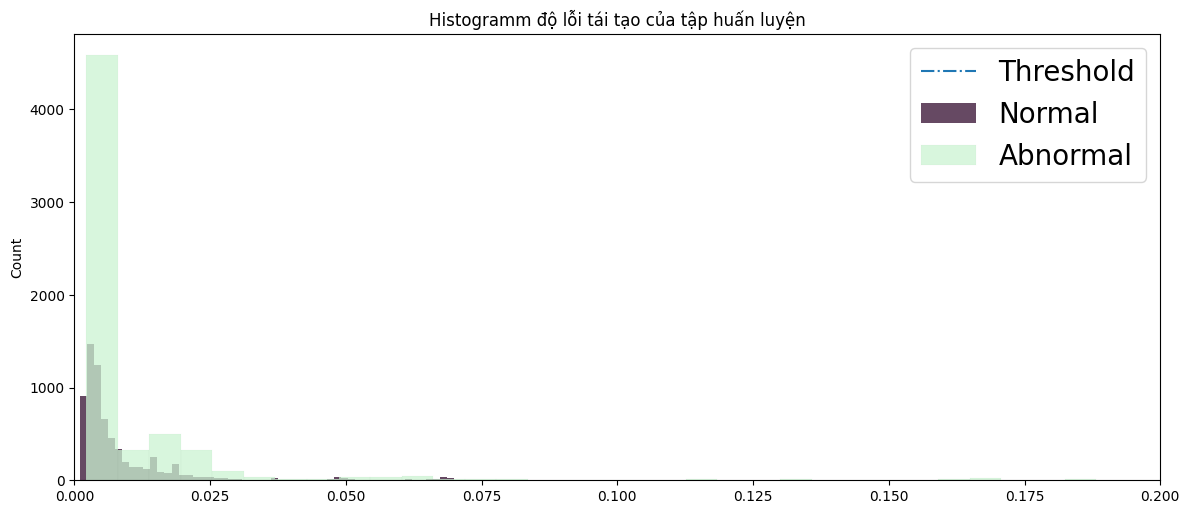

In [19]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=train_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=train_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện')
plt.show()

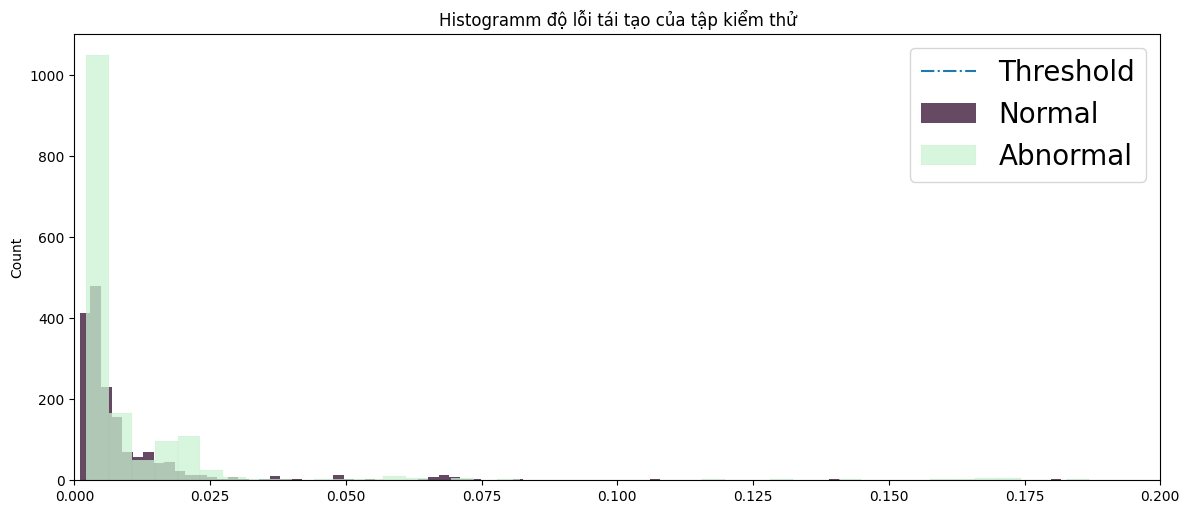

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=test_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập kiểm thử')
plt.show()